# Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

We tested our strategy using data sets that either differed in time or currency pairs. Here we take 'EURUSD_T_202212' as the example:

In [2]:
# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURGBP_T_201606.csv', names=['Time', 'Ask', 'Bid','Volume']) 
# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURGBP_T_202302.csv', names=['Time', 'Ask', 'Bid','Volume']) 
# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURGBP_T_202301.csv', names=['Time', 'Ask', 'Bid','Volume']) 
# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURGBP_T_202212.csv', names=['Time', 'Ask', 'Bid','Volume']) 

# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURUSD_T_201912.csv', names=['Time', 'Ask', 'Bid','Volume']) 
# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURUSD_T_202302.csv', names=['Time', 'Ask', 'Bid','Volume']) 
# df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURUSD_T_202301.csv', names=['Time', 'Ask', 'Bid','Volume']) 
df=pd.read_csv('/Users/yiyaoluo/Desktop/HF/DAT_ASCII_EURUSD_T_202212.csv', names=['Time', 'Ask', 'Bid','Volume']) 

We use the mean of Ask Price and Bid Price as our tick-data price here, and add 'Status' and 'Mode' Coulumns.   
Status means which position the price is and Mode means the trend is up or down.   
Give them a initial value like '0' and 'up'.   
Both are from  slide 44 of lecture 8.

In [3]:
df['Price']=(df['Ask']+df['Bid'])/2 
df['Status']=0
df['Mode']='up'
df.head()

,Time,Ask,Bid,Volume,Price,Status,Mode
0,20221201 000000257,1.04389,1.04396,0,1.043925,0,up
1,20221201 000000359,1.04390,1.04396,0,1.043930,0,up
2,20221201 000000480,1.04390,1.04397,0,1.043935,0,up
3,20221201 000000660,1.04391,1.04395,0,1.043930,0,up
4,20221201 000003295,1.04389,1.04395,0,1.043920,0,up


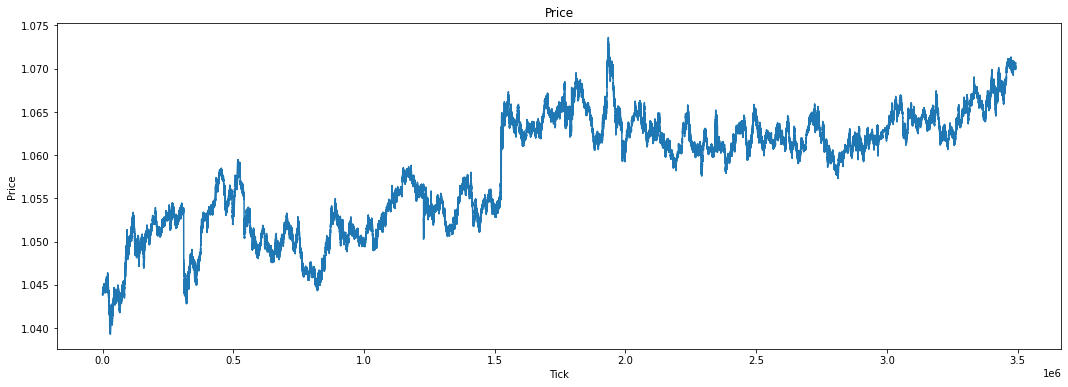

In [4]:
Price=df[['Price','Status','Mode']]
plt.figure(figsize=(18, 6))
plt.title('Price')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.plot(Price['Price'])
plt.show()

In [5]:
# (Price['Price'].std())/1000

**Regarding the setting of the threshold value:**  
    I set the value to a particular multiple of the standard deviation of the price and keep the figure within a range of 1e-05, which keeps the number of operations within a reasonable range.

In [6]:
n=1
while (Price['Price'].std()/(10**n))>=1e-04 :
    n=n+1
Price['Price'].std()/(10**n)

6.554179131791941e-05

Below is the code for the specific implementation of the algorithm in the slide 44.

In [7]:
Threshold_up = Price['Price'].std()/(10**n)
Threshold_down = Price['Price'].std()/(10**n)
S_ext = Price['Price'][0]
S_IE = Price['Price'][0]
Mode='up'

In [8]:
for i in range(Price['Price'].count()):
    S_tick = Price['Price'][i]
    if Mode == 'up':
        if (S_tick-S_ext)/S_ext >= Threshold_up:
            Mode = 'down'
#             Price.loc[i,'Mode'] =Mode
            S_ext = S_tick
            S_IE = S_tick
            Price.loc[i, 'Status'] = 1
        elif S_tick < S_ext:
            S_ext = S_tick
            if (S_IE-S_ext)/S_ext >= Threshold_down:
                S_IE = S_tick
                Price.loc[i, 'Status'] = -2
    elif Mode == 'down':

        if (S_ext-S_tick)/S_ext >= Threshold_down:
            Mode = 'up'
            S_ext = S_tick
            S_IE = S_tick
            Price.loc[i, 'Status'] = -1
        elif S_tick > S_ext:

            S_ext = S_tick
            if (S_ext-S_IE)/S_ext > Threshold_up:
                S_IE = S_tick
                Price.loc[i, 'Status'] = 2
    Price.loc[i, 'Mode'] = Mode

After dissecting the time series at intrinsic time, let us look at the first 1000 data markers.

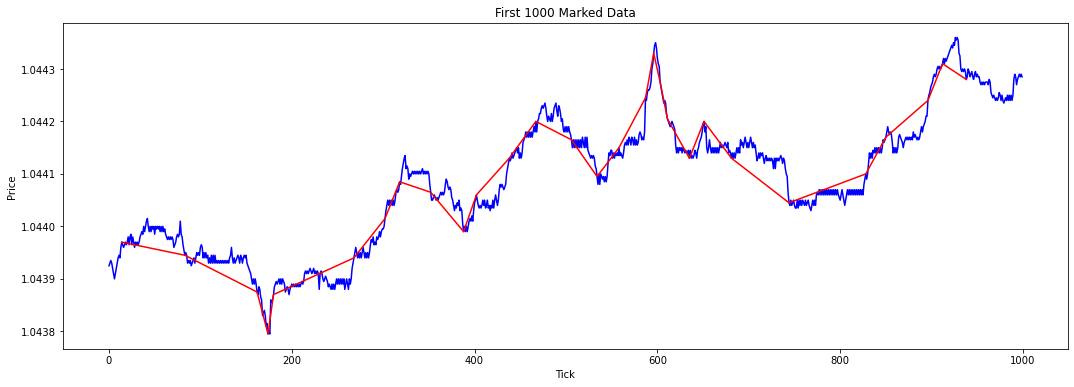

In [9]:
Key = Price[0:1000]
plt.figure(figsize=(18, 6))
plt.title('First 1000 Marked Data')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.plot(Key['Price'], c='blue')
plt.plot(Key[Key['Status'] != 0]['Price'], c='red')
plt.show()

In the diagram we can see that each event is marked in red and that the frequency of events is very appropriate

# Strategy

As the strategy we use is a high frequency trade, the selection of the strategy should be as simple as possible to reduce the time complexity of running the program. Here we use a simple but effective trading strategy.

<span class="mark"><span class="mark">**Sell**：</span>when the mode is **up** and the Status is **-1**  
 **Buy**：when the mode is **down** and the Status is **2**</span>

Note: you may need to restart the kernel to use updated packages.


set the initial value of the operate signal as -1  
when it's time to sell, change it to 0;  
when it's time to buy, change it to 1


In [10]:

Price['Signal']=-1

In [11]:
condition1=(Price['Mode']=='up')
condition2=(Price['Status']==-1)
Price.loc[condition1 & condition2, 'Signal'] = 0

In [12]:
condition1=(Price['Mode']=='down')
condition2=(Price['Status']==2)
Price.loc[condition1 & condition2, 'Signal'] = 1

# Back Test

calculate the percent change of the price each day

In [13]:
Price['pct_change']=Price['Price'].pct_change()
Price.fillna(value=0,inplace=True)

set the initial position as 0

In [14]:
Price['pos']=0

In [15]:
pos=0
for i in range(Price['Price'].count()-1):
    if Price['Signal'][i]==1:
        pos=1    
    elif Price['Signal'][i]==0:
        pos=0
    Price.loc[i+1,'pos']=pos

Calculate the cumulative returns and max drawdown of our strategy

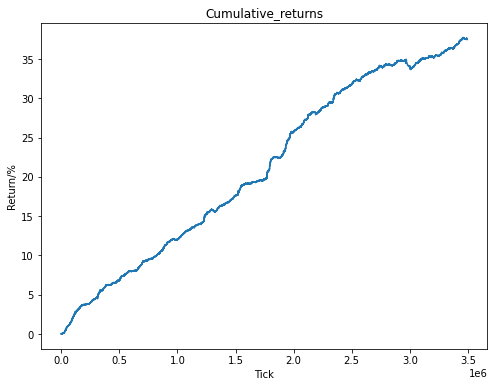

In [16]:
Price['Strategy_returns'] = Price['pos']*Price['pct_change']
Price['Cumulative_returns'] = ((1 + Price['Strategy_returns']).cumprod() - 1)*100
plt.figure(figsize=(8, 6))
plt.title('Cumulative_returns')
plt.xlabel('Tick')
plt.ylabel('Return/%')
plt.plot(Price['Cumulative_returns'])
plt.show()

In [17]:
Price['rel_drawdowns'] = (Price['Cumulative_returns'] -
                          Price['Cumulative_returns'].cummax()) / (1 + Price['Cumulative_returns'].cummax())
max_drawdown = Price['rel_drawdowns'].min()
print("max_drawdown：", -max_drawdown*100,"%")

max_drawdown： 4.005366342682476 %


In [18]:
# # 获取标普500历史价格数据
# sp500 = yf.download('^GSPC', start='2023-01-01', end='2023-02-28')

# # # 将日期列设置为索引
# # sp500.set_index('Date', inplace=True)

# # # 按月重采样并计算月度收益率
# monthly_returns = sp500['Close'].resample('M').last().pct_change()

# # 获取指定月份的收益率，例如获取2022年3月份的收益率
# Feb_2023_return = monthly_returns['2023-02']

# print("2023年2月标普500收益率：", Feb_2023_return)
